In [ ]:
import os

import librosa
import numpy as np
import pandas as pd
import soundfile as sf
from IPython.display import Audio

# from pydub import AudioSegment
from trainer import Trainer, TrainerArgs
from TTS.tts.configs.shared_configs import BaseDatasetConfig
from TTS.tts.datasets import load_tts_samples
from TTS.tts.layers.xtts.trainer.gpt_trainer import (
    GPTArgs,
    GPTTrainer,
    GPTTrainerConfig,
)
from TTS.tts.models.xtts import XttsAudioConfig
from TTS.utils.manage import ModelManager

In [2]:
OUTPUT_PATH = "../data/train/"
os.makedirs(OUTPUT_PATH, exist_ok=True)

CHEKPOINTS_PATH = "../data/orig_models"
os.makedirs(CHEKPOINTS_PATH, exist_ok=True)

### Download original models

In [3]:
# DVAE files
DVAE_CHECKPOINT_LINK = "https://coqui.gateway.scarf.sh/hf-coqui/XTTS-v2/main/dvae.pth"
MEL_NORM_LINK = "https://coqui.gateway.scarf.sh/hf-coqui/XTTS-v2/main/mel_stats.pth"

# Set the path to the downloaded files
DVAE_CHECKPOINT = os.path.join(CHEKPOINTS_PATH, os.path.basename(DVAE_CHECKPOINT_LINK))
MEL_NORM_FILE = os.path.join(CHEKPOINTS_PATH, os.path.basename(MEL_NORM_LINK))

# download DVAE files if needed
if not os.path.isfile(DVAE_CHECKPOINT) or not os.path.isfile(MEL_NORM_FILE):
    print(" > Downloading DVAE files!")
    ModelManager._download_model_files(
        [MEL_NORM_LINK, DVAE_CHECKPOINT_LINK], CHEKPOINTS_PATH, progress_bar=True
    )

In [4]:
# Download XTTS v2.0 checkpoint if needed
TOKENIZER_FILE_LINK = "https://coqui.gateway.scarf.sh/hf-coqui/XTTS-v2/main/vocab.json"
XTTS_CHECKPOINT_LINK = "https://coqui.gateway.scarf.sh/hf-coqui/XTTS-v2/main/model.pth"

# XTTS transfer learning parameters: You we need to provide the paths of XTTS model checkpoint that you want to do the fine tuning.
TOKENIZER_FILE = os.path.join(
    CHEKPOINTS_PATH, os.path.basename(TOKENIZER_FILE_LINK)
)  # vocab.json file
XTTS_CHECKPOINT = os.path.join(
    CHEKPOINTS_PATH, os.path.basename(XTTS_CHECKPOINT_LINK)
)  # model.pth file

# download XTTS v2.0 files if needed
if not os.path.isfile(TOKENIZER_FILE) or not os.path.isfile(XTTS_CHECKPOINT):
    print(" > Downloading XTTS v2.0 files!")
    ModelManager._download_model_files(
        [TOKENIZER_FILE_LINK, XTTS_CHECKPOINT_LINK], CHEKPOINTS_PATH, progress_bar=True
    )

In [11]:
SPEAKER_REFERENCE = "../data/speaker_sample.wav"
# max_sample_length
print("max_sample_length: ", librosa.load(SPEAKER_REFERENCE)[0].shape[0])
# max wav length
MAX_LENGTH = int(12.5 * 22050 + 5000)
print("maxt_text_wav: ", MAX_LENGTH)

# max text length

data = pd.read_csv("../data/train_data/train_dataset.csv", sep="|")
print("maxt_text_length: ", np.max([len(x) for x in data.iloc[:, 1]]))

max_sample_length:  374850
maxt_text_wav:  280625
maxt_text_length:  195


In [ ]:
OPTIMIZER_WD_ONLY_ON_WEIGHTS = True
START_WITH_EVAL = True
BATCH_SIZE = 1
GRAD_ACUMM_STEPS = 256
LANGUAGE = "ru"

model_args = GPTArgs(
    max_conditioning_length=375000,  # the audio you will use for conditioning latents should be less than this
    min_conditioning_length=66150,  # and more than this
    debug_loading_failures=True,  # this will print output to console and help you find problems in your ds
    max_wav_length=MAX_LENGTH,  # set this to >= the longest audio in your dataset
    max_text_length=200,
    mel_norm_file=MEL_NORM_FILE,
    dvae_checkpoint=DVAE_CHECKPOINT,
    xtts_checkpoint=XTTS_CHECKPOINT,
    tokenizer_file=TOKENIZER_FILE,
    gpt_num_audio_tokens=1026,
    gpt_start_audio_token=1024,
    gpt_stop_audio_token=1025,
    gpt_use_masking_gt_prompt_approach=True,
    gpt_use_perceiver_resampler=True,
)

audio_config = XttsAudioConfig(dvae_sample_rate=16000, output_sample_rate=24000)


In [9]:
RUN_NAME = "IM-FT-v1"
PROJECT_NAME = "dls-vd"
DASHBOARD_LOGGER = "tensorboard"
LOGGER_URI = None

In [ ]:
config = GPTTrainerConfig(
    run_eval=True,
    epochs=1000,  # assuming you want to end training manually w/ keyboard interrupt
    output_path=OUTPUT_PATH,
    model_args=model_args,
    run_name=RUN_NAME,
    project_name=PROJECT_NAME,
    run_description="""
        GPT XTTS training
        """,
    dashboard_logger=DASHBOARD_LOGGER,
    logger_uri=LOGGER_URI,
    audio=audio_config,
    batch_size=BATCH_SIZE,
    batch_group_size=48,
    eval_batch_size=BATCH_SIZE,
    num_loader_workers=8,  # consider decreasing if your jupyter env is crashing or similar
    eval_split_max_size=256,
    print_step=50,
    plot_step=100,
    log_model_step=1000,
    save_step=10000,  # ?
    save_n_checkpoints=1,  # if you want to store multiple checkpoint rather than just 1, increase this
    save_checkpoints=False,
    print_eval=False,
    optimizer="AdamW",
    optimizer_wd_only_on_weights=OPTIMIZER_WD_ONLY_ON_WEIGHTS,
    optimizer_params={"betas": [0.9, 0.96], "eps": 1e-8, "weight_decay": 1e-2},
    lr=5e-06,
    lr_scheduler="MultiStepLR",
    lr_scheduler_params={
        "milestones": [50000 * 18, 150000 * 18, 300000 * 18],
        "gamma": 0.5,
        "last_epoch": -1,
    },
    test_sentences=[
        {
            "text": "Заставить бояться или уважать. Что ценнее? Я считаю все вместе. С этой мыслью я хочу представить вам новую жемчужину Старкс Индастрис свобода. Это первая ракетная система с репульсорной технологией запуска и наведения",
            "speaker_wav": SPEAKER_REFERENCE,
            "language": LANGUAGE,
        },
        {
            "text": "Никогда не сдавайтесь, идите к своей цели! А если будет сложно – сдавайтесь. А после плотно покушайте и ляжте спать.",
            "speaker_wav": SPEAKER_REFERENCE,
            "language": LANGUAGE,
        },
    ],
)

model = GPTTrainer.init_from_config(config)

In [ ]:
TRAINING_DIR = "../data/train_data"
dataset_config = BaseDatasetConfig(
    formatter="ljspeech",
    meta_file_train="train_dataset.csv",
    language=LANGUAGE,
    path=TRAINING_DIR,
)
train_samples, eval_samples = load_tts_samples(
    dataset_config, eval_split=True, eval_split_size=0.05
)  # off eval split because of small dataset size

In [43]:
trainer = Trainer(
    TrainerArgs(
        restore_path=None,
        skip_train_epoch=False,
        start_with_eval=START_WITH_EVAL,
        grad_accum_steps=GRAD_ACUMM_STEPS,
    ),
    config,
    output_path=OUTPUT_PATH,
    model=model,
    train_samples=train_samples,
    eval_samples=eval_samples,
)

 > Training Environment:
 | > Backend: Torch
 | > Mixed precision: False
 | > Precision: float32
 | > Current device: 0
 | > Num. of GPUs: 1
 | > Num. of CPUs: 32


 | > Num. of Torch Threads: 1
 | > Torch seed: 1
 | > Torch CUDNN: True
 | > Torch CUDNN deterministic: False
 | > Torch CUDNN benchmark: False
 | > Torch TF32 MatMul: False
 > Start Tensorboard: tensorboard --logdir=../data/train/IM-FT-v1-July-11-2025_07+44PM-9aa8666

 > Model has 518442047 parameters


In [ ]:
trainer.fit()

Результат лучшего шага на eval:

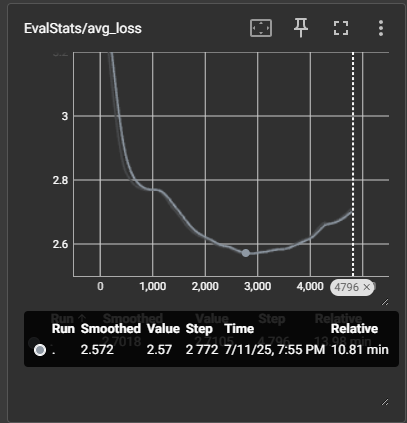

### Inference

In [ ]:
from TTS.tts.configs.xtts_config import XttsConfig
from TTS.tts.models.xtts import Xtts

checkpoint_path = (
    "../data/train/IM-FT-v1-July-11-2025_07+44PM-9aa8666/best_model_2772.pth"
)
config_file = "../data/train/IM-FT-v1-July-11-2025_07+44PM-9aa8666/config.json"
vocab_json = "../data/orig_models/vocab.json"
SPEAKER_REFERENCE = "../data/speaker_sample.wav"

In [9]:
output_wav = "./xtts-ft.wav"

print("Loading model...")
config = XttsConfig()
config.load_json(config_file)
model = Xtts.init_from_config(config)
model.load_checkpoint(
    config, checkpoint_path=checkpoint_path, vocab_path=vocab_json, use_deepspeed=False
)

Loading model...


In [ ]:
gpt_cond_latent, speaker_embedding = model.get_conditioning_latents(
    audio_path=[SPEAKER_REFERENCE]
)

text = "Никогда не сдавайтесь, идите к своей цели! А если будет сложно – сдавайтесь. А после плотно покушайте и ляжте спать."

out = model.inference(
    text,
    "ru",
    gpt_cond_latent,
    speaker_embedding,
    temperature=0.2,  # Add custom parameters here
)


In [12]:
Audio(out["wav"], rate=24000)

In [23]:
from TTS.api import TTS

In [24]:
model_name = "tts_models/multilingual/multi-dataset/xtts_v2"
tts_model = TTS(model_name).to("cuda")

In [ ]:
audio = tts_model.tts(
    text=text,
    speaker_wav=SPEAKER_REFERENCE,
    language="ru",
    temperature=0.2,
)

In [32]:
Audio(audio, rate=24000)

### Training second checkpoint:

In [ ]:
# Specify the parameters

OPTIMIZER_WD_ONLY_ON_WEIGHTS = True
START_WITH_EVAL = True
BATCH_SIZE = 1
GRAD_ACUMM_STEPS = 128  # NOTE: 256 -> 128
LANGUAGE = "ru"

model_args = GPTArgs(
    max_conditioning_length=375000,  # the audio you will use for conditioning latents should be less than this
    min_conditioning_length=66150,  # and more than this
    debug_loading_failures=True,  # this will print output to console and help you find problems in your ds
    max_wav_length=MAX_LENGTH,  # set this to >= the longest audio in your dataset
    max_text_length=200,
    mel_norm_file=MEL_NORM_FILE,
    dvae_checkpoint=DVAE_CHECKPOINT,
    xtts_checkpoint=XTTS_CHECKPOINT,
    tokenizer_file=TOKENIZER_FILE,
    gpt_num_audio_tokens=1026,
    gpt_start_audio_token=1024,
    gpt_stop_audio_token=1025,
    gpt_use_masking_gt_prompt_approach=True,
    gpt_use_perceiver_resampler=True,
)

audio_config = XttsAudioConfig(dvae_sample_rate=16000, output_sample_rate=24000)


RUN_NAME = "IM-FT-v2"  # NOTE: v1 -> v2
PROJECT_NAME = "dls-vd"
DASHBOARD_LOGGER = "tensorboard"
LOGGER_URI = None

config = GPTTrainerConfig(
    run_eval=True,
    epochs=1000,  # assuming you want to end training manually w/ keyboard interrupt
    output_path=OUTPUT_PATH,
    model_args=model_args,
    run_name=RUN_NAME,
    project_name=PROJECT_NAME,
    run_description="""
        GPT XTTS training
        """,
    dashboard_logger=DASHBOARD_LOGGER,
    logger_uri=LOGGER_URI,
    audio=audio_config,
    batch_size=BATCH_SIZE,
    batch_group_size=48,
    eval_batch_size=BATCH_SIZE,
    num_loader_workers=8,  # consider decreasing if your jupyter env is crashing or similar
    eval_split_max_size=256,
    print_step=50,
    plot_step=100,
    log_model_step=1000,
    save_step=10000,  # ?
    save_n_checkpoints=1,  # if you want to store multiple checkpoint rather than just 1, increase this
    save_checkpoints=False,
    print_eval=False,
    optimizer="AdamW",
    optimizer_wd_only_on_weights=OPTIMIZER_WD_ONLY_ON_WEIGHTS,
    optimizer_params={"betas": [0.9, 0.96], "eps": 1e-8, "weight_decay": 1e-2},
    lr=5e-06,
    lr_scheduler="ExponentialLR",  # NOTE: MultiStepLR -> ExponentialLR
    lr_scheduler_params={
        "gamma": 0.95,
    },
    test_sentences=[
        {
            "text": "Заставить бояться или уважать. Что ценнее? Я считаю все вместе. С этой мыслью я хочу представить вам новую жемчужину Старкс Индастрис свобода. Это первая ракетная система с репульсорной технологией запуска и наведения",
            "speaker_wav": SPEAKER_REFERENCE,
            "language": LANGUAGE,
        },
        {
            "text": "Никогда не сдавайтесь, идите к своей цели! А если будет сложно – сдавайтесь. А после плотно покушайте и ляжте спать.",
            "speaker_wav": SPEAKER_REFERENCE,
            "language": LANGUAGE,
        },
    ],
)

model = GPTTrainer.init_from_config(config)

TRAINING_DIR = "../data/train_data"
dataset_config = BaseDatasetConfig(
    formatter="ljspeech",
    meta_file_train="train_dataset.csv",
    language=LANGUAGE,
    path=TRAINING_DIR,
)

train_samples, eval_samples = load_tts_samples(
    dataset_config, eval_split=True, eval_split_size=0.05
)

In [ ]:
# заморозим слои для обучения, оставив только которые обрабатывают часть со speaker
non_frozen_layers = [
    "speaker_encoder",
    "conditioning_encoder",
    "proj_speaker",
    "speaker_proj",
]

for name, param in model.named_parameters():
    if any(t in name for t in non_frozen_layers):
        param.requires_grad = True
    else:
        param.requires_grad = False

In [26]:
for name, param in model.named_parameters():
    print(name)
    print(param.requires_grad)
    break

xtts.hifigan_decoder.waveform_decoder.conv_pre.bias
False


In [27]:
trainer = Trainer(
    TrainerArgs(
        restore_path=None,
        skip_train_epoch=False,
        start_with_eval=START_WITH_EVAL,
        grad_accum_steps=GRAD_ACUMM_STEPS,
    ),
    config,
    output_path=OUTPUT_PATH,
    model=model,
    train_samples=train_samples,
    eval_samples=eval_samples,
)

 > Training Environment:
 | > Backend: Torch
 | > Mixed precision: False
 | > Precision: float32
 | > Current device: 0
 | > Num. of GPUs: 1
 | > Num. of CPUs: 32
 | > Num. of Torch Threads: 1
 | > Torch seed: 1
 | > Torch CUDNN: True
 | > Torch CUDNN deterministic: False
 | > Torch CUDNN benchmark: False
 | > Torch TF32 MatMul: False
 > Start Tensorboard: tensorboard --logdir=../data/train/IM-FT-v2-July-13-2025_03+14PM-2fdb24b

 > Model has 33314124 parameters


In [ ]:
trainer.fit()

Результат лучшего шага на eval:

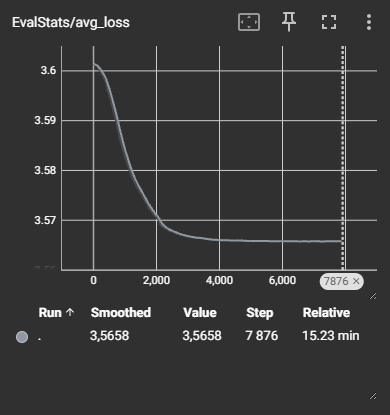

In [ ]:
from TTS.tts.configs.xtts_config import XttsConfig
from TTS.tts.models.xtts import Xtts

checkpoint_path = (
    "../data/train/IM-FT-v2-July-13-2025_03+14PM-2fdb24b/best_model_7216.pth"
)
config_file = "../data/train/IM-FT-v2-July-13-2025_03+14PM-2fdb24b/config.json"
vocab_json = "../data/orig_models/vocab.json"
SPEAKER_REFERENCE = "../data/speaker_sample.wav"

In [7]:
print("Loading model...")
config = XttsConfig()
config.load_json(config_file)
model = Xtts.init_from_config(config)
model.load_checkpoint(
    config, checkpoint_path=checkpoint_path, vocab_path=vocab_json, use_deepspeed=False
)

Loading model...


In [19]:
gpt_cond_latent, speaker_embedding = model.get_conditioning_latents(
    audio_path=[SPEAKER_REFERENCE]
)

# text = "Никогда не сдавайтесь, идите к своей цели! А если будет сложно – сдавайтесь. А после плотно покушайте и ляжте спать."
text = (
    "Я очень хочу понять как работает данная модель, но мне многое остается не ясным."
)

out = model.inference(
    text,
    "ru",
    gpt_cond_latent,
    speaker_embedding,
    temperature=0.1,  # Add custom parameters here
    length_penalty=10,
    repetition_penalty=15.0,
)

The following generation flags are not valid and may be ignored: ['length_penalty']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


In [20]:
Audio(out["wav"], rate=24000)

In [ ]:
sf.write("../data/creepy_output.wav", out["wav"], format="wav", samplerate=24000)